## I. Data import and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
sns.set_style("whitegrid")

In [2]:
#Two data sources are imported
filepath1 = 'data/Data1.csv'
data_orig1 = pd.read_csv(filepath1)
filepath2 = 'data/Data2.csv'
data_orig2 = pd.read_csv(filepath2)

In [3]:
#Function for extracting preffered data without low, middle and high income countries for last available year.

def indicators_no_income(male, female, plot_title):
    '''Function arguments:
    male, female - indicator names for both genders (input strings). 
    Function extracts data for preffered variable and total population size in countries. Then column 'Year' ir droped and DataFrame is reshaped for convenient analysis in the future.
    Last available data with total population in Poland is added in function,because it is not provided in data files.'''
    
    new_table_orig = data[(data.Indicator.isin([male,female, 'Population, total (millions)']) & 
                           (data.Year=='Last available') & 
                           (data.Country != 'Low income') & 
                           (data.Country != 'Middle income') & 
                           (data.Country != 'High income'))]
    new_table_orig = new_table_orig.drop(['Year'],axis=1)
    new_table = new_table_orig.pivot(index='Country',columns='Indicator',values='Value')
    new_table[(new_table.index=='Poland') & (new_table['Population, total (millions)'].isna())] = new_table.replace(np.nan,38.3)
    
    temp1 = new_table.loc[:,[male,female]]
    col1 = pd.Series((temp1.iloc[:,1]*100/temp1.iloc[:,0]-100))
    col2 = pd.Series((temp1.iloc[:,1]-temp1.iloc[:,0]))
    diff= pd.DataFrame({'% difference': col1,'Abs. difference':col2}).sort_values(by='% difference')
    diff_table= round(diff,1)
        
    x_min=new_table.loc[:,male].min()
    x_lim_min = (x_min-x_min/10)
    x_max=new_table.loc[:,male].max()
    x_lim_max = (x_max+x_max/10)
    y_min=new_table.loc[:,female].min()
    y_lim_min = (y_min-y_min/10)
    y_max=new_table.loc[:,female].max()
    y_lim_max = (y_max+y_max/10)
        
    plt.figure(figsize=(8,8))
    new_plot=sns.scatterplot(x=male, 
                y=female,
                size = 'Population, total (millions)',sizes=(50,500),
                hue=new_table.index, data=new_table,alpha=0.8)
    plt.legend(loc='upper left',ncol=1,framealpha=0.5,borderpad=0.5,labelspacing=1.8,bbox_to_anchor=(1.05,0.9,0.1,0.1),borderaxespad=0.05)
    plt.title('\n'.join(wrap(plot_title,60)), fontsize=14)
    plt.xlabel('\n'.join(wrap(male,60)))
    plt.ylabel('\n'.join(wrap(female,60)))
    plt.xlim(left=x_lim_min,right=x_lim_max)
    plt.ylim(bottom=y_lim_min,top=y_lim_max)
    directory= 'img/'
    fig_name = '{}scatter_{}.png'.format(directory,plot_title)
    plt.savefig(fname=fig_name, dpi=300,bbox_inches='tight')
    
    print('Female indicator difference from male indicator (as %, when value of male indicator is 100; and as absolute difference)')
    print(diff_table)
    
    return new_table, new_plot

In [4]:
#Function for plotting general graphs.

def general_graph(indicator,title,y_bottom,y_top):
    '''Function arguments:
    indicator - select indicator name from data (string);
    title - preffered title name (string);
    y_bottom, y_top - limits for y axis'''
    graph_name = data[data.Indicator == indicator].sort_values(by=['Country','Year']).reset_index(drop = True)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(x='Year',y='Value',hue='Country',data=graph_name,ax=ax)
    plt.title(title,fontsize=14)
    plt.ylabel(indicator)
    plt.xticks(rotation=45)
    plt.ylim(bottom=y_bottom,top=y_top)
    plt.legend(loc=0,ncol=4,framealpha=0.5,borderpad=0.2)
    directory= 'img/'
    fig_name = '{}general_{}.png'.format(directory,indicator)
    plt.savefig(fname=fig_name, dpi=300)
    

## II. Data cleaning and preparing for visualisations

In [5]:
#Drop columns 'Country Code', 'Series Code' and '2019[YR2019]'
data_orig1=data_orig1.drop(['Country Code','Series Code'],axis=1)
data_orig2=data_orig2.drop(['Country Code','Series Code','2019 [YR2019]'],axis=1)

In [6]:
#data_orig1.columns

In [7]:
#data_orig2.columns

In [8]:
#Merge two tables from different databases
data_orig=pd.concat([data_orig1,data_orig2],ignore_index=True)

In [9]:
#Convert missing values to NaN
data_orig=data_orig.replace('..',np.nan)
#data_orig.head()

In [10]:
#Rename columns
data_orig.rename(columns={'Country Name':'Country','Series Name':'Indicator','1960 [YR1960]':'1960', '1965 [YR1965]':'1965',
       '1970 [YR1970]':'1970', '1975 [YR1975]':'1975', '1980 [YR1980]':'1980', '1985 [YR1985]':'1985',
       '1990 [YR1990]':'1990', '1995 [YR1995]':'1995', '2000 [YR2000]':'2000', '2005 [YR2005]':'2005',
       '2010 [YR2010]':'2010', '2015 [YR2015]':'2015', 'last_av':'Last available'},inplace=True)

In [11]:
#Only rows with not-null values in column 'Indicator' are taken for future analysis (last 5 rows from each primary table should be removed, because contain some metadata)
data_orig = data_orig[data_orig['Indicator'].notna()]

In [12]:
#Reshape DataFrame
data=pd.melt(frame=data_orig,id_vars=['Country','Indicator'],var_name='Year', value_name='Value')
#data.head(10)

In [13]:
#Convert column 'Value' type from string to float
data['Value'] = data['Value'].astype(float)

In [14]:
#Converting total population values to millions
data.loc[data.Indicator == 'Population, total', 'Value'] = data.Value/1000000

In [15]:
#Rounding values to 1 decimal
data['Value'] = np.round(data['Value'],decimals=1)

In [16]:
#Rename indicator 
data= data.replace('Population, total','Population, total (millions)')

In [17]:
#Extract data with birth rate and death rate for calculation of natural population change
birth_rate = data[data.Indicator=='Birth rate, crude (per 1,000 people)'].sort_values(by=['Country','Year']).reset_index(drop=True)
death_rate = data[data.Indicator=='Death rate, crude (per 1,000 people)'].sort_values(by=['Country','Year']).reset_index(drop=True)

In [18]:
#Create table for calculation of Natural population change
nat_ch = data[data.Indicator=='Death rate, crude (per 1,000 people)'].sort_values(by=['Country','Year']).reset_index(drop=True)
nat_ch.rename(columns={'Death rate, crude (per 1,000 people)':'Natural population change, crude (per 1,000 people)'},inplace=True)

In [19]:
#Calculate new value 'Natural population change' in the table nat_ch (based on birth and death rates)
nat_ch['Value'] = np.where(birth_rate['Value'] == death_rate['Value'], 0, birth_rate['Value'] - death_rate['Value']) 
nat_ch = nat_ch.drop(['Indicator'],axis=1)

## III. How do Lithuania look among other countries by general indicators?

### Life expectancy

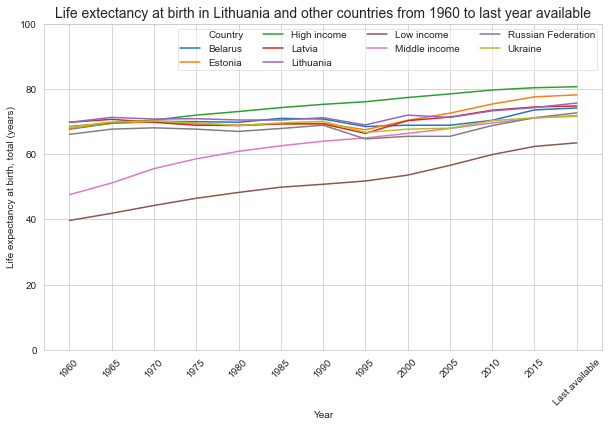

In [20]:
general_graph('Life expectancy at birth, total (years)','Life extectancy at birth in Lithuania and other countries from 1960 to last year available',0,100)

##### Life expectancy in Lithuania is higher than in low or middle income countries. It is slowly increasing, but is still lower than in high income countries. 

### Natural population change

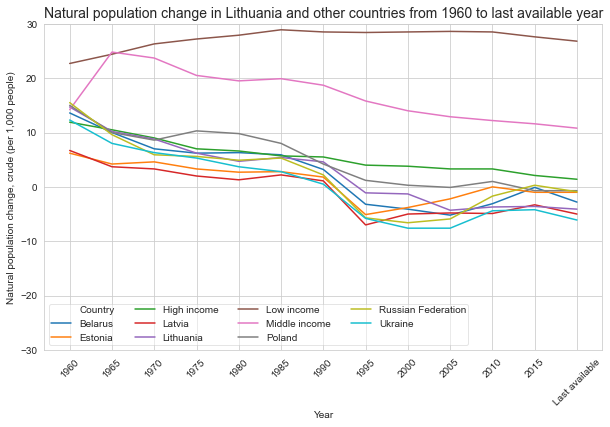

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='Year',y='Value',hue='Country',data=nat_ch,ax=ax)
plt.title("Natural population change in Lithuania and other countries from 1960 to last available year",fontsize=14)
plt.ylabel('Natural population change, crude (per 1,000 people)')
plt.xticks(rotation=45)
plt.ylim(bottom=-30,top=30)
plt.legend(loc=0,ncol=4,framealpha=0.5,borderpad=0.2)
directory= 'img/'
fig_name = '{}general_Natural population change, crude (per 1,000 people).png'.format(directory)
plt.savefig(fname=fig_name, dpi=300)

##### Natural population change in Lithuania is negative for about 15 years. It means that our population is ageing and population size is decreasing (because more people dies every year that are born). This trend can be seen in our neigbour countries, but overall in low, middle and even in high income countries, natural population change is still positive.
###### Of course, to make sure that our conclusion is correct, we have to analyse migration data together with natural population change. This data is not available in our files, so we leave it as to-do task.

### Fertility

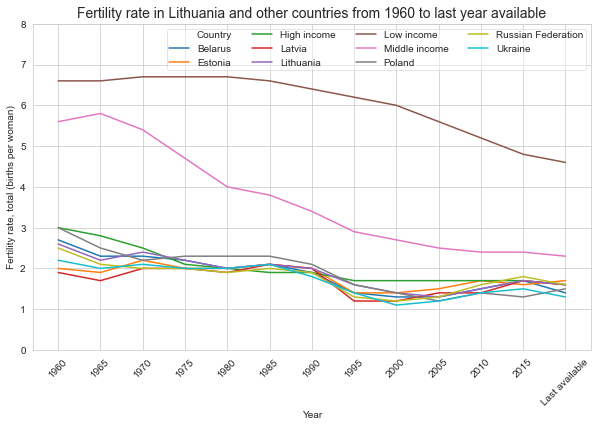

In [22]:
general_graph('Fertility rate, total (births per woman)','Fertility rate in Lithuania and other countries from 1960 to last year available',0,8)

##### Fertility rate in Lithuania is very similar to our neighbours and high income countries. 1 woman gives about 1.5 births during her childbearing years. Low fertility rates might be one of the reasons for negative natural population change.

### Suicide mortality

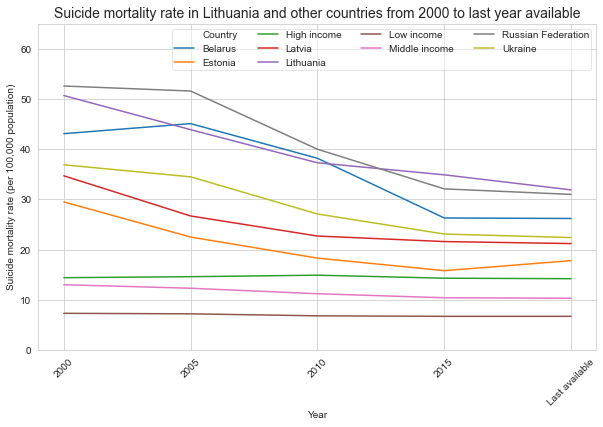

In [23]:
general_graph('Suicide mortality rate (per 100,000 population)','Suicide mortality rate in Lithuania and other countries from 2000 to last year available',0,65)

##### Number of suicides in Lithuania is slowly decreasing. During last few years, less than 700 people commited suicides per year, while there were 1.5 thousands of suicides ten years ago. Despite that, suicide rate in Lithuania is still highest among compared countries. But this data is very complicated to analyze, because suicide in general has a lot of problems with registration. Suicide rates are also highly influenced by culture in countries.

### Employers

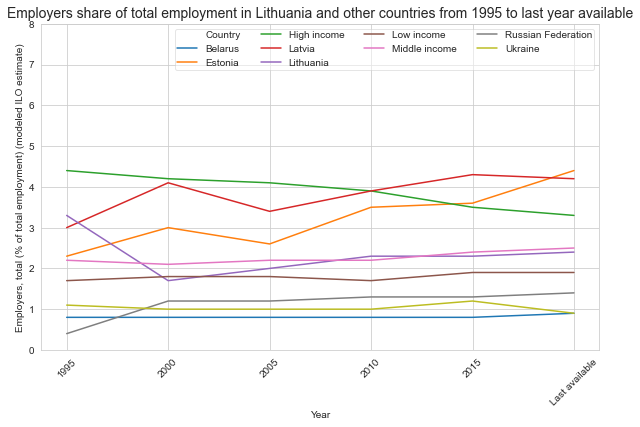

In [24]:
general_graph('Employers, total (% of total employment) (modeled ILO estimate)','Employers share of total employment in Lithuania and other countries from 1995 to last year available',0,8)

##### Explanation: 
"Employers, total (% of total employment) (modeled ILO estimate)"

Employers are those workers who, working on their own account or with one or a few partners, hold the type of jobs defined as a "self-employment jobs" i.e. jobs where the remuneration is directly dependent upon the profits derived from the goods and services produced), and, in this capacity, have engaged, on a continuous basis, one or more persons to work for them as employee(s).

##### Lithuania has very similar share of employers in general population as middle income countries for last 20 years.

## IV. What are the differences between men and woman in various countries?

Female indicator difference from male indicator (as %, when value of male indicator is 100; and as absolute difference)
                    % difference  Abs. difference
Country                                          
Estonia                     11.8              8.7
Latvia                      13.7              9.6
Lithuania                   13.8              9.8
Belarus                     14.7             10.2
Russian Federation          14.7             10.0
Ukraine                     15.0             10.0


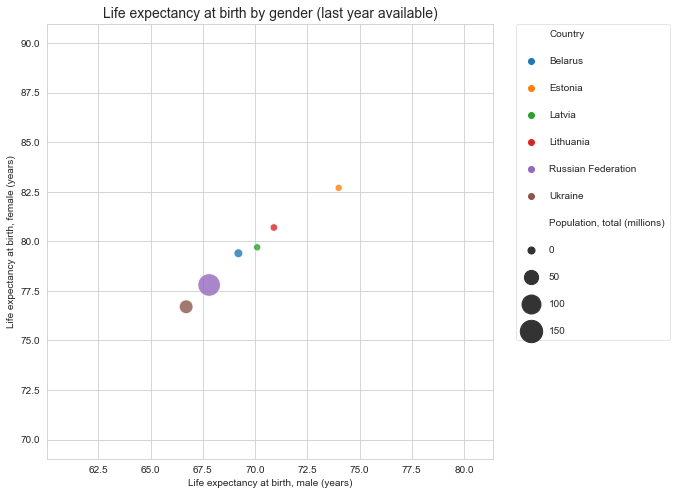

In [25]:
LE_bg,LE_bg_plot = indicators_no_income('Life expectancy at birth, male (years)','Life expectancy at birth, female (years)','Life expectancy at birth by gender (last year available)')

##### Women lives 9-10 years longer than men in Lithuania and neighbour countries. Estonia has the lowest life expectancy gap - 8.7 years. Few reasons for this will be presented in other graphics.

### Health and health behaviour

Female indicator difference from male indicator (as %, when value of male indicator is 100; and as absolute difference)
                    % difference  Abs. difference
Country                                          
Ukraine                    -84.7            -34.8
Lithuania                  -83.6            -48.6
Russian Federation         -83.2            -46.5
Belarus                    -82.5            -38.7
Latvia                     -80.6            -30.3
Estonia                    -78.4            -24.0


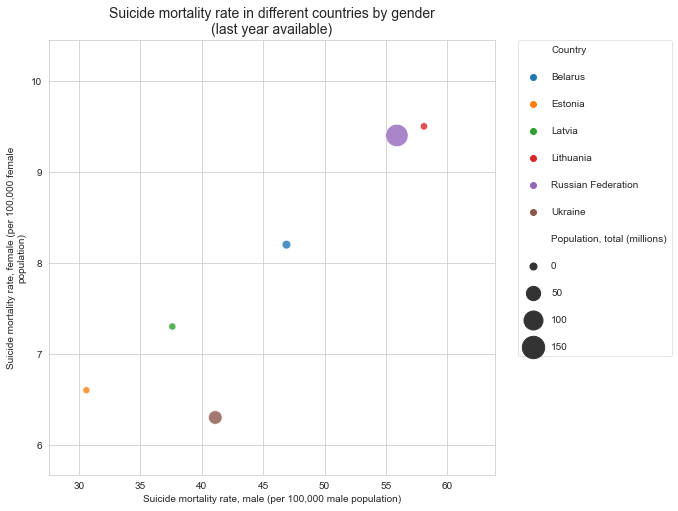

In [26]:
suicide,suicide_plot = indicators_no_income('Suicide mortality rate, male (per 100,000 male population)','Suicide mortality rate, female (per 100,000 female population)','Suicide mortality rate in different countries by gender (last year available)')

##### There are huge differences of suicide rates between genders. In Lithuania and neighbour countries suicide rates are about 80 per cent higher than for men than women. This might be one of the reasons for large life expectancy gap between genders.

Female indicator difference from male indicator (as %, when value of male indicator is 100; and as absolute difference)
                    % difference  Abs. difference
Country                                          
Belarus                    -77.2            -35.6
Ukraine                    -71.5            -33.9
Russian Federation         -59.9            -34.9
Latvia                     -49.8            -25.4
Lithuania                  -43.9            -16.7
Estonia                    -37.7            -14.8
Poland                     -29.6             -9.8


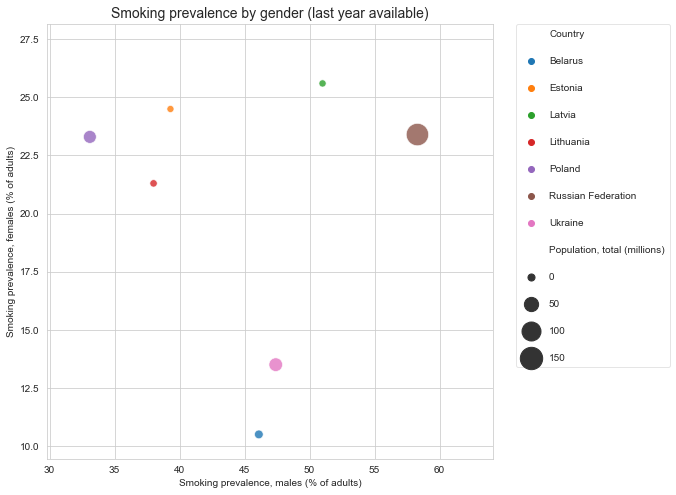

In [27]:
smoking,smoking_plot = indicators_no_income('Smoking prevalence, males (% of adults)','Smoking prevalence, females (% of adults)','Smoking prevalence by gender (last year available)')

##### Men are also likely to be smokers than women, especially in Belarus, Ukraine and Russian Federation. Unhealthy behaviour is also one of the reasons for shorter life, because smoking increases a risk of lung, bronchus and tracheal cancer and other diseases.

Female indicator difference from male indicator (as %, when value of male indicator is 100; and as absolute difference)
                    % difference  Abs. difference
Country                                          
Poland                     -75.5            -14.5
Estonia                    -74.7            -14.5
Latvia                     -73.7            -16.0
Lithuania                  -72.3            -18.0
Ukraine                    -71.6            -10.1
Belarus                    -69.4            -12.5
Russian Federation         -69.0            -12.9


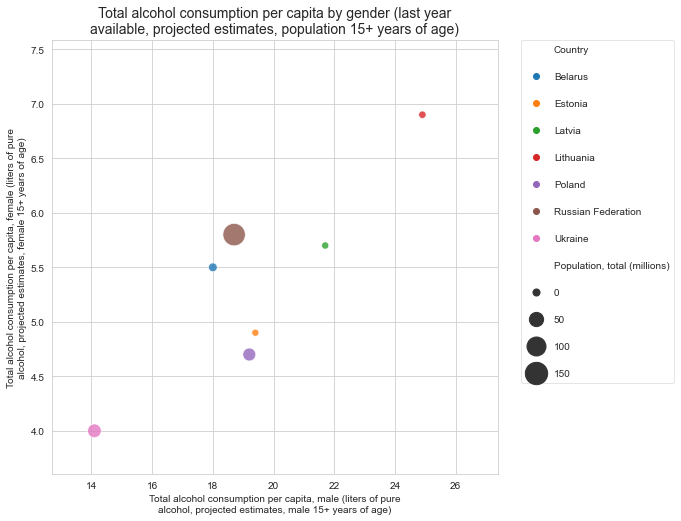

In [28]:
alcohol,alcohol_plot = indicators_no_income('Total alcohol consumption per capita, male (liters of pure alcohol, projected estimates, male 15+ years of age)','Total alcohol consumption per capita, female (liters of pure alcohol, projected estimates, female 15+ years of age)','Total alcohol consumption per capita by gender (last year available, projected estimates, population 15+ years of age)')

##### Alcohol consumption is highest in Lithuania compared to neighbour countries. Also the absolute difference of total alcohol consumed per capita between genders is in Lithuania - men consumes 18 liters more than women! Differences between genders are in all compared countries. This is probably another reason for differences in life expectancy.

Female indicator difference from male indicator (as %, when value of male indicator is 100; and as absolute difference)
                    % difference  Abs. difference
Country                                          
Estonia                    -70.1             -4.7
Lithuania                  -57.6             -1.9
Latvia                     -55.9             -3.3
Russian Federation         -52.6             -1.0
Belarus                    -50.0             -0.6
Ukraine                    -36.4             -0.4


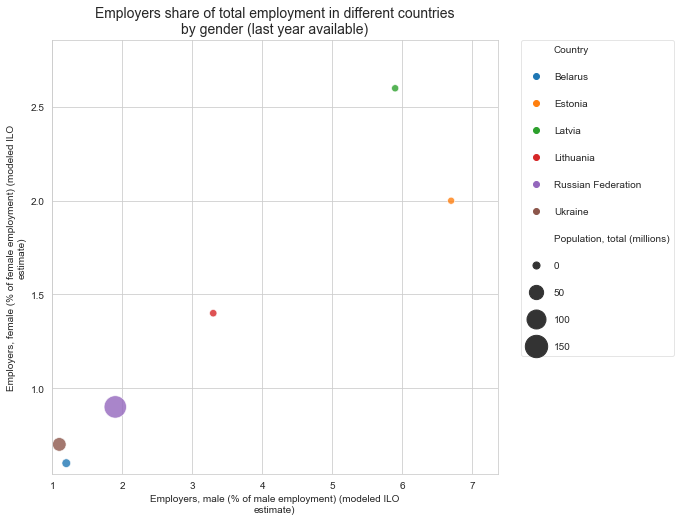

In [29]:
employers,employers_plot = indicators_no_income('Employers, male (% of male employment) (modeled ILO estimate)','Employers, female (% of female employment) (modeled ILO estimate)','Employers share of total employment in different countries by gender (last year available) ')

##### Men are more likely to be employers than a women. The highest share of female employers is in Latvia and Estonia, but Estonia has the highest % difference between men and women.

### Social indicators

Female indicator difference from male indicator (as %, when value of male indicator is 100; and as absolute difference)
                    % difference  Abs. difference
Country                                          
Poland                       1.0              0.2
Estonia                      4.4              0.7
Latvia                       7.6              1.2
Russian Federation           9.7              1.2
Lithuania                   10.7              1.7
Belarus                     13.8              1.5
Ukraine                     14.9              2.1


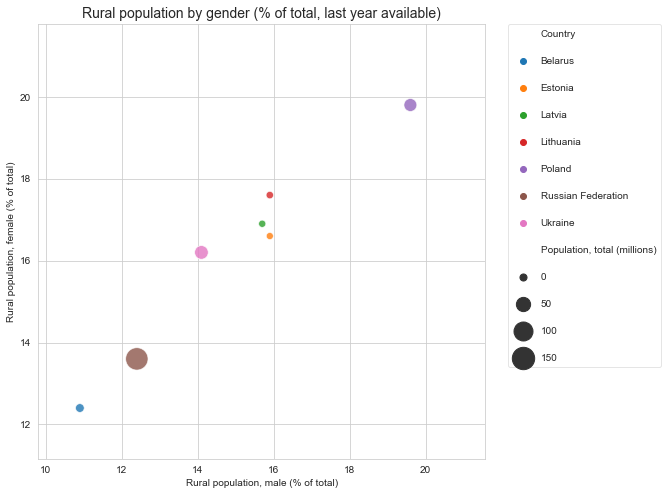

In [30]:
rural_pop,rural_pop_plot = indicators_no_income('Rural population, male (% of total)','Rural population, female (% of total)','Rural population by gender (% of total, last year available)')

##### Among compared countries, higher share of women than men lives in rural places, but differences between genders are very small. The highest share of population living in rural places is in Poland.

Female indicator difference from male indicator (as %, when value of male indicator is 100; and as absolute difference)
                    % difference  Abs. difference
Country                                          
Ukraine                    -11.2             -2.9
Russian Federation          -9.6             -2.6
Belarus                     -9.3             -2.3
Latvia                      -8.2             -2.7
Estonia                     -7.4             -2.7
Lithuania                   -7.4             -2.6
Poland                      -7.3             -2.1


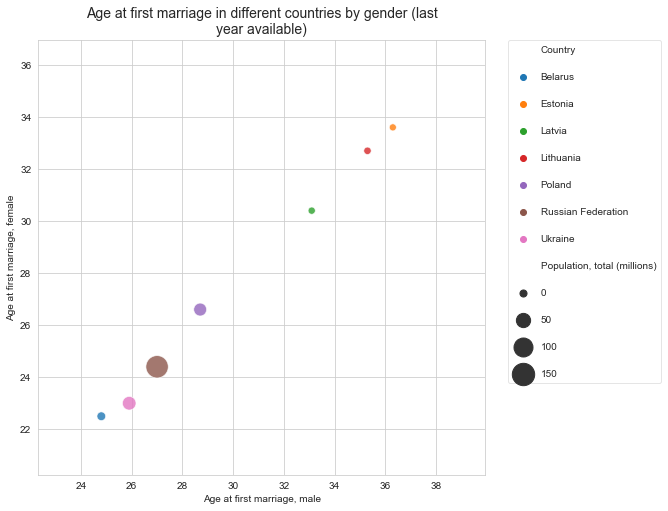

In [31]:
age_at_mar,age_at_mar_plot = indicators_no_income('Age at first marriage, male', 'Age at first marriage, female','Age at first marriage in different countries by gender (last year available)')

##### Data shows that women gets married for the first time about more than 2 years earlier than men. Estonians and Lithuanians marry the latest from all compared countries, and Belarusians marry being youngest.

Female indicator difference from male indicator (as %, when value of male indicator is 100; and as absolute difference)
                    % difference  Abs. difference
Country                                          
Ukraine                    -26.7            -12.5
Russian Federation          -9.4             -3.6
Latvia                      -4.5             -2.5
Lithuania                   -3.3             -2.1
Estonia                      2.4              1.6
Poland                       8.7              4.3
Belarus                     12.3              5.8


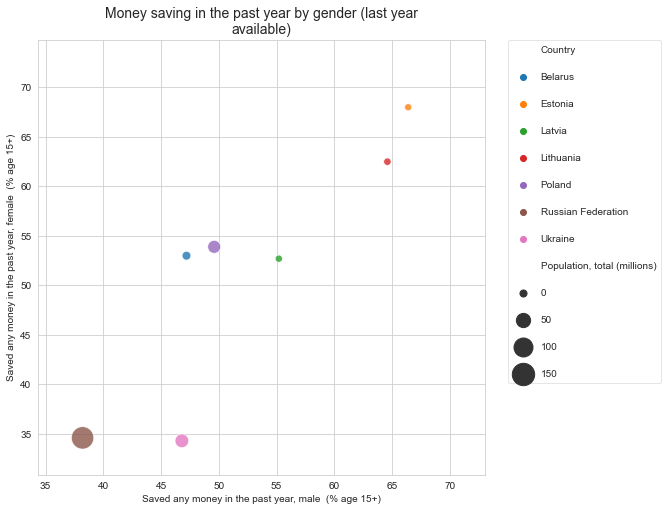

In [32]:
saved_money,saved_money_plot = indicators_no_income('Saved any money in the past year, male  (% age 15+)','Saved any money in the past year, female  (% age 15+)','Money saving in the past year by gender (last year available)')

##### More women than men in Estonia, Poland and Belarus saved any money in the past year. For women in other countries the situation was opposite - less women than men saved any money in the past year.

## V. Conclusions:
* In general, Lithuania looks like high or middle income country, especially when such demographic indicators as life expectancy at birth, natural population change and fertility are compared;
* There are significant differences of life expectancy, smoking prevalence, alcohol consumption, suicide mortality and age at first marriage between genders;
* The trend of differences between genders are similar in all compared countries.